In [1]:
!pip install rtdl
!pip install libzero==0.0.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/output-2.zip 

Archive:  /content/drive/MyDrive/output-2.zip
   creating: data/
   creating: data/lenta_evaluating/
  inflating: data/lenta_evaluating/C_eval.npy  
  inflating: data/lenta_evaluating/N_eval.npy  
   creating: data/lenta_training/
  inflating: data/lenta_training/y_train.npy  
  inflating: data/lenta_training/N_test.npy  
  inflating: data/lenta_training/C_train.npy  
  inflating: data/lenta_training/y_test.npy  
  inflating: data/lenta_training/y_val.npy  
  inflating: data/lenta_training/C_test.npy  
  inflating: data/lenta_training/N_train.npy  
  inflating: data/lenta_training/N_val.npy  
  inflating: data/lenta_training/C_val.npy  
   creating: data/lenta/
  inflating: data/lenta/merged_train.csv  


In [4]:
from typing import Any, Dict

import numpy as np
import rtdl
import scipy.special
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import zero

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
zero.improve_reproducibility(seed=123456)

123456

In [6]:
task_type = 'regression'

In [32]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.6 MB/s 


In [33]:
from category_encoders import CatBoostEncoder

In [34]:
path_to_dataset = '/content/data/lenta_training'
C_train = np.load(path_to_dataset + '/C_train.npy', allow_pickle=True)
N_train = np.load(path_to_dataset + '/N_train.npy').astype('float32')
y_train = np.load(path_to_dataset + '/y_train.npy').astype('float32')
cbe = CatBoostEncoder()
C_train = cbe.fit_transform(C_train, y_train).values.astype('float32')
C_val = cbe.transform(np.load(path_to_dataset + '/C_val.npy', allow_pickle=True)).values.astype('float32')
N_val = np.load(path_to_dataset + '/N_val.npy').astype('float32')
y_val = np.load(path_to_dataset + '/y_val.npy').astype('float32')
C_test = cbe.transform(np.load(path_to_dataset + '/C_test.npy', allow_pickle=True)).values.astype('float32')
N_test = np.load(path_to_dataset + '/N_test.npy').astype('float32')
y_test = np.load(path_to_dataset + '/y_test.npy').astype('float32')

In [35]:
X_train, X_val, X_test = [np.concatenate([C, N], axis=1) for C, N in zip([C_train, C_val, C_test], [N_train, N_val, N_test])]

In [66]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer()
X = {}
y = {}
X['train'],  X['val'], X['test'], y['train'], y['val'], y['test'] = X_train, X_val, X_test, y_train, y_val, y_test
preprocess = sklearn.preprocessing.StandardScaler().fit(X['train'])
impute = imp.fit(X['train'])

X = {
    k: impute.fit_transform(v)
    for k, v in X.items()
}
X = {
    k: torch.tensor(preprocess.fit_transform(v), device=device)
    for k, v in X.items()
}
y = {k: torch.tensor(v, device=device) for k, v in y.items()}

# !!! CRUCIAL for neural networks when solving regression problems !!!
if task_type == 'regression':
    y_mean = y['train'].mean().item()
    y_std = y['train'].std().item()
    y = {k: (v - y_mean) / y_std for k, v in y.items()}
else:
    y_std = y_mean = None

if task_type != 'multiclass':
    y = {k: v.float() for k, v in y.items()}

Выбрал модель FT-Transformer, так как при должном обучении она выучивается на табличных данных сравнимо с CatBoost: https://arxiv.org/abs/2106.11959

Еще один плюс – как PyTorch модель она дифференцируема, соответственно, поэтому я и отказался от использования CatBoost (который учить гораздо комфортнее), чтобы не заниматься black-box оптимизацией (что гораздо более сложная задача, на мой взгляд), а оптимизироваться по градиенту (а еще можно достаточно разумно включить в модель ценообразования информацию о других переменных, которые мы не можем менять).

In [67]:
d_out =  1
model = rtdl.FTTransformer.make_default(
    n_num_features=X_train.shape[1],
    cat_cardinalities=None,
    last_layer_query_idx=[-1],  
    d_out=d_out,
)

lr = 1e-4
weight_decay = 0.0

model.to(device)
optimizer = (
    model.make_default_optimizer()
    if isinstance(model, rtdl.FTTransformer)
    else torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
)
loss_fn = (
    F.binary_cross_entropy_with_logits
    if task_type == 'binclass'
    else F.cross_entropy
    if task_type == 'multiclass'
    else F.mse_loss
)

In [71]:
def apply_model(x_num, x_cat=None):
    if isinstance(model, rtdl.FTTransformer):
        return model(x_num, x_cat)
    elif isinstance(model, (rtdl.MLP, rtdl.ResNet)):
        assert x_cat is None
        return model(x_num)
    else:
        raise NotImplementedError(
            f'Looks like you are using a custom model: {type(model)}.'
            ' Then you have to implement this branch first.'
        )


@torch.no_grad()
def evaluate(part):
    model.eval()
    prediction = []
    for batch in zero.iter_batches(X[part], 1024):
        prediction.append(apply_model(batch))
    prediction = torch.relu(torch.cat(prediction)).squeeze(1).cpu().numpy()
    target = y[part].cpu().numpy()
    if task_type == 'binclass':
        prediction = np.round(scipy.special.expit(prediction))
        score = sklearn.metrics.accuracy_score(target, prediction)
    elif task_type == 'multiclass':
        prediction = prediction.argmax(1)
        score = sklearn.metrics.accuracy_score(target, prediction)
    else:
        assert task_type == 'regression'
        score = sklearn.metrics.mean_squared_error(target, prediction) ** 0.5 * y_std
    return score

batch_size = 256
train_loader = zero.data.IndexLoader(len(X['train']), batch_size, device=device)


progress = zero.ProgressTracker(patience=100)

print(f'Test score before training: {evaluate("test"):.4f}')

Test score before training: 2.6789


In [76]:
n_epochs = 5
report_frequency = len(X['train']) // batch_size // 5
for epoch in range(1, n_epochs + 1):
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = X['train'][batch_idx]
        y_batch = y['train'][batch_idx]
        loss = loss_fn(apply_model(x_batch).squeeze(1), y_batch)
        loss.backward()
        optimizer.step()
        if iteration % report_frequency == 0:
            print(f'(epoch) {epoch} (batch) {iteration} (loss) {loss.item():.4f}')

    val_score = evaluate('val')
    test_score = evaluate('test')
    print(f'Epoch {epoch:03d} | Validation score: {val_score:.4f} | Test score: {test_score:.4f}', end='')
    progress.update((-1 if task_type == 'regression' else 1) * val_score)
    if progress.success:
        print(' <<< BEST VALIDATION EPOCH', end='')
    print()
    if progress.fail:
        break

(epoch) 1 (batch) 0 (loss) 0.4695
(epoch) 1 (batch) 1922 (loss) 0.0915
(epoch) 1 (batch) 3844 (loss) 0.1886
(epoch) 1 (batch) 5766 (loss) 0.2865
(epoch) 1 (batch) 7688 (loss) 0.1339
(epoch) 1 (batch) 9610 (loss) 0.1435
Epoch 001 | Validation score: 2.2283 | Test score: 2.4936 <<< BEST VALIDATION EPOCH
(epoch) 2 (batch) 0 (loss) 0.8139
(epoch) 2 (batch) 1922 (loss) 0.0891
(epoch) 2 (batch) 3844 (loss) 0.1919
(epoch) 2 (batch) 5766 (loss) 0.2828
(epoch) 2 (batch) 7688 (loss) 0.1318
(epoch) 2 (batch) 9610 (loss) 0.1457
Epoch 002 | Validation score: 2.2055 | Test score: 2.4659 <<< BEST VALIDATION EPOCH
(epoch) 3 (batch) 0 (loss) 0.2952
(epoch) 3 (batch) 1922 (loss) 0.0843
(epoch) 3 (batch) 3844 (loss) 0.1853
(epoch) 3 (batch) 5766 (loss) 0.2842
(epoch) 3 (batch) 7688 (loss) 0.1348
(epoch) 3 (batch) 9610 (loss) 0.1471
Epoch 003 | Validation score: 2.1886 | Test score: 2.4430 <<< BEST VALIDATION EPOCH
(epoch) 4 (batch) 0 (loss) 0.3099
(epoch) 4 (batch) 1922 (loss) 0.0769
(epoch) 4 (batch) 38

In [89]:
def wape(y_true: np.array, y_pred: np.array):
  return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))

@torch.no_grad()
def evaluate_wape(part):
    model.eval()
    prediction = []
    for batch in zero.iter_batches(X[part], 1024):
        prediction.append(apply_model(batch))
    prediction = torch.relu(torch.cat(prediction)).squeeze(1).cpu().numpy()
    target = y[part].cpu().numpy()
    prediction = prediction * y_std + y_mean
    target = target * y_std + y_mean
    score = wape(target, prediction)
    return score

batch_size = 256
progress = zero.ProgressTracker(patience=100)

print(f'WAPE: {evaluate_wape("test"):.4f}')

WAPE: 0.4931


In [80]:
path_to_eval = '/content/data/lenta_evaluating'
C = cbe.transform(np.load(path_to_eval + '/C_eval.npy', allow_pickle=True)).values.astype('float32')
N = np.load(path_to_eval + '/N_eval.npy').astype('float32')
X_eval = np.concatenate([C, N], axis=1) 
X_eval = preprocess.transform(impute.transform(X_evel)).astype('float32')

In [ ]:
!pip install shap

In [88]:
X_eval = torch.tensor(X_eval).to(device)

In [90]:
del C, N, C_train, N_train

In [103]:
@torch.no_grad()
def make_preds():
    model.eval()
    prediction = []
    for iteration, batch_idx in enumerate(preds_loader):
        x_batch = X_eval[batch_idx]
        prediction.append(apply_model(x_batch))
    prediction = torch.relu(torch.cat(prediction)).squeeze(1).cpu().numpy()
    prediction = prediction * y_std + y_mean
    return prediction, iteration
preds_loader = zero.data.IndexLoader(len(X_eval), batch_size, device=device, shuffle=False)
batch_size = 1024
preds, batch_idx = make_preds()

In [105]:
preds.shape

(2666217,)

In [107]:
np.save('preds2.npy', preds)

In [306]:
from torch import nn, optim

from itertools import chain

class PriceOptim(nn.Module):
    def __init__(self, C_shape, N_shape, num_hidden, num_units):
      super(PriceOptim, self).__init__()

      self.C_shape, self.N_shape = C_shape, N_shape
      self.num_hidden, self.num_units = num_hidden, num_units

      self.mask = torch.zeros(self.C_shape[1] + self.N_shape[1]).to('cuda' if torch.cuda.is_available() else 'cpu').float()
      
      self.mask[15:18] = 1.

      self.Linear = nn.Sequential(
          nn.Linear(self.C_shape[1] + self.N_shape[1], self.num_units),
          nn.ReLU(),
          *list(chain.from_iterable([[nn.Linear(self.num_units, self.num_units),
          nn.ReLU()] for i in range(self.num_hidden)])),
          nn.Linear(self.num_units, 1),
          nn.ReLU()
      )

    def forward(self, input):
      embedding = self.Linear(input)
      #да, немного странно одинаковую цену подавать, тк люди лучше реагируют на скидки, но для простоты моделирования
      output = input * (1. - self.mask) + torch.tile(embedding, [1, self.mask.shape[0]])  * self.mask
      return output

In [326]:
price_opt = PriceOptim((0, 13), (0, 12), 2, 25).to(device)

In [327]:
optimizer = torch.optim.Adam(price_opt.parameters(), lr=1e-4)

In [328]:
@torch.no_grad()
def get_real_revenue():
  num_sales_real = torch.relu(apply_model(x_batch).detach()) * y_std + y_mean
  price_real = x_batch[:, 16:19]
  rev_real = torch.sum(num_sales_real * price_real, axis=1).mean()
  return rev_real

def get_opt_revenue():
   output = price_opt(x_batch)
   mask = torch.zeros(output.shape[1]).to('cuda' if torch.cuda.is_available() else 'cpu').float()
   mask[15:18] = 1.
   num_sales_opt_model =( torch.relu(apply_model(output)) * y_std + y_mean)/3
   price_opt_model = output * mask
   rev_opt_model = torch.mean(torch.mean(torch.mean(num_sales_opt_model * price_opt_model, axis=1)))
   return rev_opt_model



In [329]:
n_epochs = 5
revs_real, revs_opt = [], []

report_frequency = len(X['test']) // batch_size // 5

batch_size = 1024
priceopt_loader = zero.data.IndexLoader(len(X_test), batch_size, device=device)
for epoch in range(1, n_epochs + 1):
    for iteration, batch_idx in enumerate(priceopt_loader):
        price_opt.train()
        optimizer.zero_grad()
        x_batch = X['test'][batch_idx]
        y_batch = y['test'][batch_idx]
        rev_real = get_real_revenue()
        rev_opt_model = get_opt_revenue()
        loss = - rev_opt_model**2
        loss.backward()
        optimizer.step()
        if iteration % report_frequency == 0:
            print(f'(epoch) {epoch} (batch) {iteration} (loss) {rev_opt_model.item():.4f}')
        revs_real.append(rev_real.detach().cpu().numpy())
        revs_opt.append(rev_opt_model.detach().cpu().numpy())


(epoch) 1 (batch) 0 (loss) 0.0001
(epoch) 1 (batch) 80 (loss) 0.0067
(epoch) 1 (batch) 160 (loss) 0.0182
(epoch) 1 (batch) 240 (loss) 0.0311
(epoch) 1 (batch) 320 (loss) 0.0714
(epoch) 1 (batch) 400 (loss) 0.1387
(epoch) 2 (batch) 0 (loss) 0.1136
(epoch) 2 (batch) 80 (loss) 0.2476
(epoch) 2 (batch) 160 (loss) 0.3857
(epoch) 2 (batch) 240 (loss) 0.4935
(epoch) 2 (batch) 320 (loss) 0.9494
(epoch) 2 (batch) 400 (loss) 1.3732
(epoch) 3 (batch) 0 (loss) 1.1835
(epoch) 3 (batch) 80 (loss) 1.8812
(epoch) 3 (batch) 160 (loss) 2.6755
(epoch) 3 (batch) 240 (loss) 3.0473
(epoch) 3 (batch) 320 (loss) 6.1821
(epoch) 3 (batch) 400 (loss) 9.8743
(epoch) 4 (batch) 0 (loss) 8.7266
(epoch) 4 (batch) 80 (loss) 15.8733
(epoch) 4 (batch) 160 (loss) 31.0461
(epoch) 4 (batch) 240 (loss) 43.9006
(epoch) 4 (batch) 320 (loss) 157.4877
(epoch) 4 (batch) 400 (loss) 253.7248
(epoch) 5 (batch) 0 (loss) 193.7178
(epoch) 5 (batch) 80 (loss) 326.3239
(epoch) 5 (batch) 160 (loss) 423.3615
(epoch) 5 (batch) 240 (loss) 3

Тут вижу еще три проблемы:

а) Модель FT-Transformer не доучена, соответственно плохо моделирует спрос, слабо реагирует на повышение цены

б) Нужно учить две модели одновременно, по типу GAN'ов, как в статье https://arxiv.org/pdf/1706.03459.pdf, например

в) И даже так возникает много вопросов к процедуре: а именно как регулировать силу оптимизаторов (в частности, с этим у меня возникли проблемы при написании курсовой: https://github.com/VileBody/OEAuctionsTermPaper

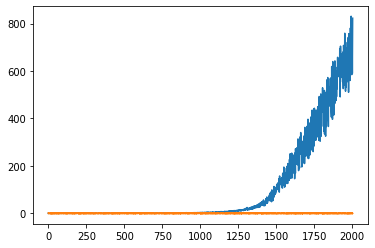

In [331]:
from matplotlib import pyplot as plt 
plt.plot(np.arange(len(revs_real)), revs_opt)
plt.plot(np.arange(len(revs_real)), revs_real)